# Monte Carlo Methods

* No need of the complete knowledge of the environment
* Based on sequences of states, actions and rewards.

## Monte Carlo Prediction

* *first visit* MC method
* *every visit* MC method


## Monte Carlo Control

Policy improvement similar to DP.
Policy evaluation is based on (recorded) episodes.
Using the returns for each state to update the value function.

In [1]:
!pip install -r ../requirements.txt

In [2]:
import dm_env
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass, field
from collections import defaultdict


@dataclass(frozen=True, unsafe_hash=True, eq=True)
class Step:
    state: int = field(compare=True, hash=True)
    action: int = field(compare=True, hash=True)
    reward: float = field(compare=False, hash=False)  # t+1
    discount: float = field(compare=False, hash=False)


def monte_carlo_exploring_starts(environment: dm_env.Environment, action_count: int,
                                 number_of_episodes: int = 10, episode_length: int = 20, number_of_reports: int = 10, seed: int = 1):

    specs = environment.observation_spec()
    state_count = specs.maximum - specs.minimum + 1

    rng = np.random.RandomState(seed)
    action_value = rng.uniform(0., 1., (state_count, action_count))  # Q
    policy = rng.randint(0, action_count-1, (state_count,))
    returns = defaultdict(list)  # maps Steps to returns
    report_period = max(1, number_of_episodes // number_of_reports)

    for episode in tqdm(range(1, number_of_episodes+1)):
        # choose initial state and action
        s_0 = rng.randint(0, state_count)
        a_0 = rng.randint(0, action_count)
        timestep = environment.step(a_0)

        # generate episode following policy
        episodes = [Step(s_0, a_0, timestep.reward, timestep.discount)]
        for _ in range(episode_length):
            state = environment.current_state_index
            action = policy[state]
            timestep = environment.step(action)
            episodes.append(
                Step(state, action, timestep.reward, timestep.discount))

            if timestep.last():
                environment.reset()
                break

        G = 0
        for t, step in sorted(enumerate(episodes), reverse=True):
            G = step.discount*G + step.reward

            if step not in episodes[:t]:
                returns[step].append(G)
                action_value[step.state, step.action] = np.mean(returns[step])
                policy[state] = np.argmax(action_value[state, :])

        # not in text book
        policy = np.argmax(action_value, axis=1)

        if episode % report_period == 0:
            yield action_value, policy


returning specs


 19%|█▉        | 378/2000 [00:00<00:04, 398.99it/s]

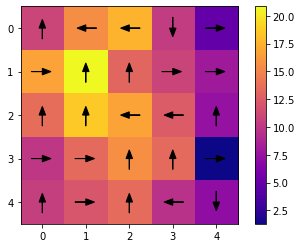

 40%|███▉      | 799/2000 [00:02<00:03, 364.85it/s]

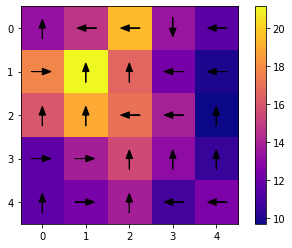

 59%|█████▊    | 1173/2000 [00:03<00:02, 360.19it/s]

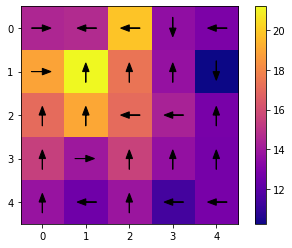

 79%|███████▉  | 1576/2000 [00:04<00:01, 352.63it/s]

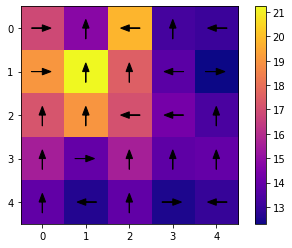

 99%|█████████▊| 1973/2000 [00:05<00:00, 357.73it/s]

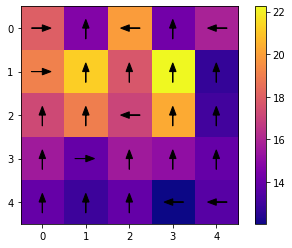

100%|██████████| 2000/2000 [00:06<00:00, 331.73it/s]


action value (Q)


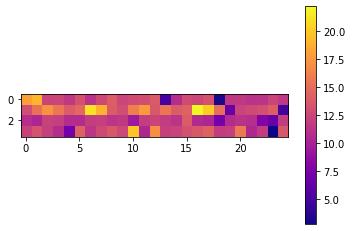

In [3]:
import nbimporter
import matplotlib.pyplot as plt

from chapter_3.finite_markov_decision_processes import GridWorld, Position, BeamAction
from chapter_4.dynamic_programming import draw_2d

WIDTH = 5
HEIGHT = 5


beam_actions = {
    Position(1, 0): BeamAction(1, 4, reward=10.),   # A
    Position(3, 0): BeamAction(3, 2, reward=5.),    # B
}

env = GridWorld(width=WIDTH, height=HEIGHT, beam_actions=beam_actions)


for action_value, policy in monte_carlo_exploring_starts(environment=env, action_count=4,
                                                         number_of_episodes=2000, episode_length=500, number_of_reports=5):
    value = np.max(action_value, axis=1)

    draw_2d(value=value, policy=policy, width=WIDTH)

print("action value (Q)")
plt.imshow(np.transpose(action_value), cmap='plasma')
plt.colorbar()
plt.show()


In [4]:
import dm_env
from dm_env import specs
from typing import Sequence, Any


class BlackJack(dm_env.Environment):
    """
    actions
        hit: one more card
        stick: stop

    cards:
        As(1 or 11) , 2 - 10, 3*10

    reward 
    when game ended
     * +1  > 17
     * 0     17
     * -1  < 17 or > 21

    else 0
    """

    def __init__(self, seed: int = 1) -> None:
        self._seed = seed
        self._cards = [*range(1, 11), 10, 10, 10]  # 1 is As
        self._reset()
        self._rng = np.random.RandomState(self._seed)

    def reset(self) -> dm_env.TimeStep:
        self._reset()
        return dm_env.restart(observation=0)

    def step(self, action) -> dm_env.TimeStep:
        """
        0: hit
        1: stick
        """

        if action == 0:
            card = self._rng.choice(self._cards)
            if card == 1 and self.state < 11:  # As
                card = 11
            self.state += card
            if self.state > 21:
                return dm_env.termination(reward=-1., observation=self.state)
            elif self.state == 21:
                return dm_env.termination(reward=1., observation=self.state)

            return dm_env.transition(reward=0., observation=self.state)

        else:
            if self.state == 17:
                reward = 0.
            elif self.state < 17:
                reward = -1.
            else:
                reward = 1.
            return dm_env.termination(reward=reward, observation=self.state)

    def observation_spec(self) -> specs.BoundedArray:
        return specs.BoundedArray(
            shape=(1,),
            dtype=int,
            name="sum of cards",
            minimum=0,
            maximum=21,
        )

    def action_spec(self) -> specs.DiscreteArray:
        return specs.BoundedArray(
            shape=(1,),
            dtype=int,
            name="hit or stick",
            minimum=0,
            maximum=1,
        )

    def _reset(self):
        # self._rng = np.random.RandomState(self._seed)
        self.state = 0

    @property
    def current_state_index(self) -> int:
        return self.state

    @property
    def current_state_index(self) -> int:
        return self.state

    @property
    def available_states(self) -> Sequence[Any]:
        yield 0
        yield 1


  0%|          | 0/500 [00:00<?, ?it/s]

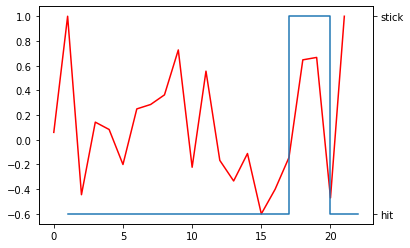

 28%|██▊       | 140/500 [00:00<00:00, 1399.15it/s]

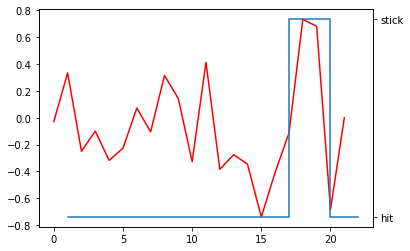

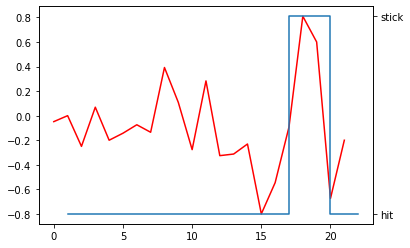

 60%|██████    | 300/500 [00:00<00:00, 1080.96it/s]

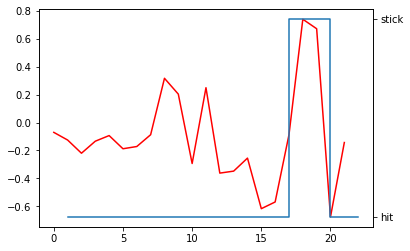

 97%|█████████▋| 486/500 [00:00<00:00, 1372.40it/s]

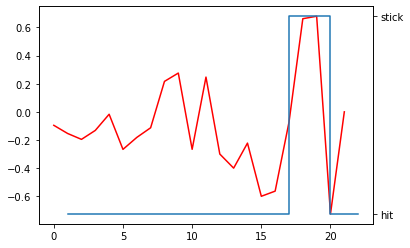

100%|██████████| 500/500 [00:00<00:00, 993.64it/s] 


In [5]:
env = BlackJack()

for action_value, policy in monte_carlo_exploring_starts(environment=env, action_count=2,
                                                         number_of_episodes=500, episode_length=21, number_of_reports=5):
    # plt.imshow(np.transpose(action_value), cmap='plasma')
    # print(f"action_value: {np.max(action_value, axis=1)}")
    # print(f"policy: {policy.shape}")
    cards = range(1, policy.shape[0]+1)
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(np.max(action_value, axis=1), color='red')
    ax2.step(cards, policy)
    plt.yticks(np.arange(2), ['hit', 'stick'])
    plt.show()


# Monte Carlo Control without Exploring Starts

* ***on policy***: evaluate and improve the policy which is used to generate the data
* ***off policy***: evaluate and improve the policy different to that which was used to generate the data

In [6]:
def on_policy_first_visit_mc_control(environment: dm_env.Environment, epsilon: float, action_count: int,
                                     number_of_episodes: int = 10, episode_length: int = 20, number_of_reports: int = 10, seed: int = 1):

    specs = environment.observation_spec()
    state_count = specs.maximum - specs.minimum + 1
    report_period = max(1, number_of_episodes // number_of_reports)

    rng = np.random.RandomState(seed)

    action_value = rng.uniform(0., 1., (state_count, action_count))  # Q
    policy = rng.uniform(0., 1., (state_count, action_count))  # pi
    # policy = rng.randint(0, action_count-1, (state_count,))
    returns = defaultdict(list)  # maps Steps to returns

    for episode in tqdm(range(1, number_of_episodes+1)):
        # choose initial state and action
        s_0 = rng.randint(0, state_count)
        a_0 = rng.randint(0, action_count)
        timestep = environment.step(a_0)

        # generate episode following policy
        episodes = [Step(s_0, a_0, timestep.reward, timestep.discount)]
        for _ in range(episode_length):
            state = environment.current_state_index
            # epsilon greedy
            if rng.random() < epsilon:
                action = rng.randint(0, policy.shape[1] - 1)
            else:
                action = np.argmax(policy, axis=1)[state]
            timestep = environment.step(action)
            episodes.append(
                Step(state, action, timestep.reward, timestep.discount))

            if timestep.last():
                environment.reset()
                break

        G = 0
        for t, step in sorted(enumerate(episodes), reverse=True):
            G = step.discount*G + step.reward

            if step not in episodes[:t]:
                returns[step].append(G)
                action_value[step.state, step.action] = np.mean(returns[step])
                a_star = np.argmax(action_value[state, :])
                mask = np.zeros_like(policy[state])
                mask[a_star] = 1.
                policy[state] = epsilon/state_count + (1-epsilon)*mask

        if episode % report_period == 0:
            yield action_value, policy


  0%|          | 0/500 [00:00<?, ?it/s]

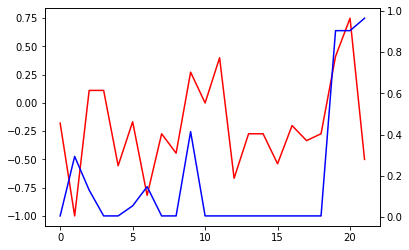

 20%|██        | 100/500 [00:00<00:00, 878.07it/s]

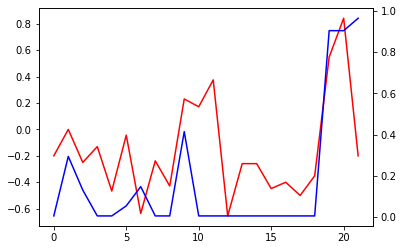

 40%|████      | 200/500 [00:00<00:00, 906.05it/s]

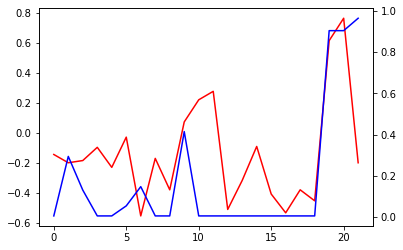

 60%|██████    | 300/500 [00:00<00:00, 913.02it/s]

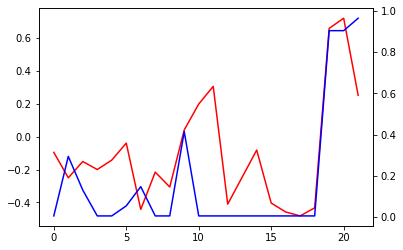

 80%|████████  | 400/500 [00:00<00:00, 922.98it/s]

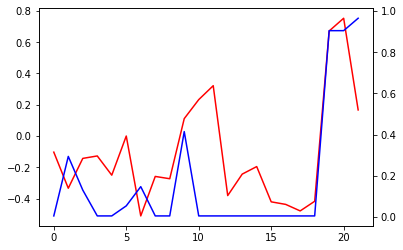

100%|██████████| 500/500 [00:00<00:00, 917.49it/s]


In [7]:
env = BlackJack()

for action_value, policy in on_policy_first_visit_mc_control(environment=env, action_count=2, epsilon=0.1,
                                                         number_of_episodes=500, episode_length=21, number_of_reports=5):
    cards = range(1, policy.shape[0]+1)
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(np.max(action_value, axis=1), color='red')
    ax2.plot(policy[:,1], color='blue')
    plt.show()

## Off-policy Prediction via Importance Sampling

Use two policies in order to enable exploration:

* ***target policy***: The optimal policy ($\pi$)
* ***behavior policy***: Policy to generate training data ($b$)

Advantage: Target policy can be greedy, while the behavior policy retains the ability to explore new trajectories.

Necessary condition (*assumption of coverage*)

\begin{align}
\pi(a|s) > 0 \Rightarrow b(b|s) > 0
\end{align}

### Importance Sample Ratio

The probability of trajectory $A_t, S_{t+1}, A_{t+1}, \cdots, S_T$ prior given $S_t$ following policy $\pi$ is called importance sampling ratio.

The probability is given by

\begin{align}
\operatorname {Pr}\left\{ A_t, S_{t+1}, A_{t+1}, \cdots, S_T \; | \; S_t, A_{t:T} \sim \pi \right\} = \prod_{k=t}^{T-1} \pi\left( A_k|S_k \right)p\left( S_{k+1} | S_k, A_k \right)
\end{align}

As the transition probability is policy invariant, the ratio is given by

\begin{align}
\rho_{t:T-1} := \prod_{k=t}^{T-1} \frac{\pi\left( A_k|S_k \right)}{b\left( A_k|S_k \right)}
\end{align}

This allows to transfer the return followed policy $b$ to the target value

\begin{align}
\mathbb{E}\left[ \rho_{t:T-1} G_t  | S_t=s \right] = v_\pi(s)
\end{align}

Define the set of all timesteps where state $s$ is visited $\mathfrak{I}(s)$. Then the *ordinary importance sampling* is defined as

\begin{align}
V(s) := \frac{\sum_{t \in \mathfrak{I}(s)} \rho_{t:T(t)-1}G_t}{\left| \mathfrak{I}(s) \right|}
\end{align}

And the *weighted importance sampling* (preferred) is defined as

\begin{align}
V(s) := \frac{\sum_{t \in \mathfrak{I}(s)} \rho_{t:T(t)-1}G_t}{\sum_{t \in \mathfrak{I}(s)} \rho_{t:T(t)-1}}
\end{align}

### Example 5.4

Given target policy for Blackjack that only *stick* when user has the sum of $20$ or $21$, else *hit*.
We are just interested in the state where the user has a sum of $13$.
Asses can be switched to $1$ or $11$. The player already has one Ass.

In [8]:
# todo

## Incremental Implementation

Given the policy as weights $W_k$ the value can be estimated with

\begin{align}
V_n := \frac{\sum_{k=1}^{n-1} W_kG_k}{\sum_{k=1}^{n-1} W_k}
\end{align}

Following with $C_n := \sum_{k=1}^n W_k$ and using $\frac{a}{b} = 1-\frac{a-b}{b}$

\begin{align}
V_{n+1} &= \frac{\sum_{k=1}^{n-1}W_kG_k + W_nG_n}{\sum_{k=1}^{n-1} W_k + W_n} \\
&= \frac{C_{n-1}}{C_n}V_n + \frac{W_nG_n}{C_n} \\
&= V_n - V_n\frac{C_n - C_{n-1}}{C_n} + \frac{W_nG_n}{C_n} \\
&= V_n + \frac{W_n}{C_n}\left[ G_n-V_n \right]
\end{align}

## Off-policy Monte Carlo Control

In [9]:
from typing import List, Sequence
from tqdm import tqdm


def create_episode(environment: dm_env.Environment, epsilon: float, policy: np.array, episode_length: int,
                   rng: np.random.RandomState) -> List[Step]:

    # choose initial state and action
    # s_0 = rng.randint(0, state_count)
    # a_0 = rng.randint(0, action_count)
    # timestep = environment.step(a_0)
    episode = []
    for _ in range(episode_length):

        state = environment.current_state_index
        # epsilon greedy
        if rng.random() < epsilon:
            action = rng.randint(0, policy.shape[1] - 1)
        else:
            action = np.argmax(policy, axis=1)[state]
        timestep = environment.step(action)
        episode.append(
            Step(state, action, timestep.reward, timestep.discount))

        if timestep.last():
            environment.reset()
            break

    return episode


def off_policy_mc_control(environment: dm_env.Environment, epsilon: float, action_count: int,
                          number_of_episodes: int = 10, episode_length: int = 20, number_of_reports: int = 10, seed: int = 1) -> Sequence:

    specs = environment.observation_spec()
    state_count = specs.maximum - specs.minimum + 1
    report_period = max(1, number_of_episodes // number_of_reports)

    rng = np.random.RandomState(seed)

    Q = rng.uniform(0., 1., (state_count, action_count))  # action_value
    C = np.zeros((state_count, action_count))
    target_policy = np.argmax(Q, axis=1)  # pi
    policy = rng.randint(0, action_count-1, (state_count,))

    for episode_index in tqdm(range(1, number_of_episodes+1)):

        # generate episode following policy
        behavior_policy = rng.uniform(0., 1., (state_count, action_count))  # b
        episode = create_episode(environment=environment, epsilon=epsilon,
                                 policy=behavior_policy, episode_length=episode_length)

        W = 1.  # accumulated importance ratio
        G = 0.  # returns

        for t, step in sorted(enumerate(episode), reverse=True):
            G = step.discount*G + step.reward

            C[step.state, step.action] += W
            Q[step.state, step.action] += W/C[step.state,
                                              step.action]*(G - Q[step.state, step.action])

            target_policy[step.state] = np.argmax(Q[step.state, :])
            if step.action != target_policy[step.state]:
                break

            W = W/behavior_policy[step.state, step.action]

        if episode_index % report_period == 0:
            yield action_value, policy


## Discounting-aware Importance Sampling

Define *flat partial returns* until horizon *h*

\begin{align}
G_{t:h} = R_{t+1} + R_{t+2} + \cdots + R_h
\end{align}

Then the *discounting-aware ordinary importance sampling* estimator is defined as

\begin{align}
V(s) := \frac{\sum_{t \in \mathfrak{I}(s)} \left((1-\gamma)\sum_{h=t+1}^{T(t)-1}\gamma^{h-t-1}\rho_{t:h-1}\bar G_{t:h} + \gamma^{T(t)-t-1}\rho_{t:T(t)-1}\bar G_{t:T(t)} \right)}{\left| \mathfrak{I}(s) \right|}
\end{align}

and the *discounting-aware weighted importance sampling* estimator is defined as

\begin{align}
V(s) := \frac{\sum_{t \in \mathfrak{I}(s)} \left((1-\gamma)\sum_{h=t+1}^{T(t)-1}\gamma^{h-t-1}\rho_{t:h-1}\bar G_{t:h} + \gamma^{T(t)-t-1}\rho_{t:T(t)-1}\bar G_{t:T(t)} \right)}{\sum_{t \in \mathfrak{I}(s)} \left((1-\gamma)\sum_{h=t+1}^{T(t)-1}\gamma^{h-t-1}\rho_{t:h-1} + \gamma^{T(t)-t-1}\rho_{t:T(t)-1}\right)}
\end{align}

## Per-decision Importance Sampling

The *per decision importance sampling* is defined by

\begin{align}
\tilde G_t = \rho_{t:t}R_{t+1} + \gamma \rho_{t:t+1}R_{t+2} + \gamma^2 \rho_{t:t+2}R_{t+3} + \cdots + \gamma^{T-t-1}\rho_{t:T-1}R_T 
\end{align}

The corresponding *ordinary importance sampling* looks as

\begin{align}
V(s) = \frac{\sum_{t\in \mathfrak{I}(s)}\tilde G_t}{\left|\mathfrak{I}(s)\right|}
\end{align}


## Summary

### Advantages over DP methods

* learning directly from an environment without model
* supports simulation or sample models (off policy)
* efficient to focus on a subset of the states
* discussed later: more robust on violating the Markov property (no bootstrap)